In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import decomposition

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import inconsistent
from scipy.spatial.distance import pdist
from sklearn.ensemble import HistGradientBoostingRegressor

import nltk 
from nltk.corpus import stopwords
from nltk.tokenize.casual import casual_tokenize
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from nltk.stem.wordnet import WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
nltk.download('stopwords')

from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Popolil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
pd.set_option('display.width', 50)
pd.set_option('display.max_columns', 20)

In [210]:
df = pd.read_csv('avito_room.csv', names=['title', 'url', 'price', 'address', 'dist_to_metro', 'agent', 'describe', 'metro'],
                low_memory=False)

In [211]:
df

,title,url,price,address,dist_to_metro,agent,describe,metro
0,"Комната 16 м² в 3-к., 6/9 эт.",https://www.avito.ru/moskva/komnaty/komnata_16...,20000,"ул. Красного Маяка, 13Ак2",", 1,6 км",Не указан,[],", 1,6 км"
1,"Комната 12 м² в 2-к., 1/12 эт.",https://www.avito.ru/moskva/komnaty/komnata_12...,15000,"Широкая ул., 4к1",", 800 м",Агентство,['Написать'],", 800 м"
2,"Комната 14 м² в 4-к., 1/5 эт.",https://www.avito.ru/moskva/komnaty/komnata_14...,15000,"ул. Артюхиной, 25",", 800 м",Не указан,"['Написать', 'Не указан']",", 800 м"
3,"Комната 24,6 м² в 4-к., 2/4 эт.",https://www.avito.ru/moskva/komnaty/komnata_24...,6500,"Москва, Новоданиловский проезд, 4",", 800 м",Не указан,"['Написать', 'Не указан', 'Написать']",", 800 м"
4,"Комната 11 м² в 1-к, 1/2 эт.",https://www.avito.ru/moskva/komnaty/komnata_11...,7000,Малая Семёновская ул.,", 400 м",Агентство,"['Написать', 'Не указан', 'Написать', 'Написать']",", 400 м"
...,...,...,...,...,...,...,...,...
865,"Комната 16 м² в 2-к., 6/12 эт.",https://www.avito.ru/moskva/komnaty/komnata_16...,12000,"Бирюлёвская ул., 49к1",", 3,4 км",Не указан,Не указан,", 3,4 км"
866,"Комната 10 м² в 3-к., 6/9 эт.",https://www.avito.ru/moskva/komnaty/komnata_10...,16000,"Елецкая ул., 16к2",", 900 м",Не указан,Написать,", 900 м"
867,"Комната 16 м² в 3-к., 15/16 эт.",https://www.avito.ru/moskva/komnaty/komnata_16...,20000,"Голубинская ул., 24к1",", 1,2 км",Не указан,Не указан,", 1,2 км"
868,"Комната 16 м² в 3-к., 3/7 эт.",https://www.avito.ru/moskva/komnaty/komnata_16...,25000,"Тверская ул., 30/2с1",", 100 м",Не указан,Не указан,", 100 м"


## Преобразование и очистка данных

In [212]:
df = df.drop_duplicates(keep='last')

In [213]:
#Плолощадь комнаты
df['m2'] = df['title'].apply(lambda x: x.split()[1].replace(',', '.'))

#Количество комнат в квартире
df['r_apart'] = df['title'].apply(lambda x: x.split()[4].split('-')[0])

#На каком этаже?
df['floor'] = df['title'].apply(lambda x: x.split()[5].split('/')[0])

#Этажей в доме
def floors_in_house(x):
    try:
        return x.split()[5].split('/')[1]
    except IndexError:
        return np.nan
df['floors_in_house'] = df['title'].apply(floors_in_house)

In [214]:
#Расстояние до метро
def dist_to_metro(x):
    try:
        x = x.split()
        if 'км' in x:
            x = float(x[1].replace(',', '.')) * 1000
            return x
        elif 'Не' in x:
            return np.nan
        else:
            return x[1]   
    except IndexError:
        return np.nan
    except ValueError:
        return np.nan
df['dist_to_metro'] = df['dist_to_metro'].apply(dist_to_metro)

In [215]:
df.isnull().sum()

title                0
url                  0
price                0
address              0
dist_to_metro      121
agent                0
describe             0
metro                0
m2                   0
r_apart              0
floor                0
floors_in_house     38
dtype: int64

In [216]:
#Заполняю пропущенные значения
df['dist_to_metro'] = df.dist_to_metro.fillna(df['dist_to_metro'].median())
df['floors_in_house'] = df['floors_in_house'].fillna(df['floors_in_house'].mode()[0])

In [217]:
df.agent.unique()

array(['Не указан', 'Агентство',
       'Квартирник-комнаты, койкоместа Москва без залога и комиссий!',
       'СВЕТЛЫЙ ДОМ', 'Сеть общежитий и хостелов HotelHot',
       '"АСТ" Недвижимость', 'VIP-hostel', 'МосКВ койко-места посуточно',
       'ARENA HOSTEL', 'АН "Dream-rent"'], dtype=object)

In [218]:
def is_agent(x):
    agent = ['Недвижимость', 'Агентство', 'АН "Dream-rent"', '"АСТ" Недвижимость']
    if x in agent:
        return 1
    else:
        return 0
df['is_agent'] = df['agent'].apply(is_agent)

def is_hotel(x):
    hotel = ['СВЕТЛЫЙ ДОМ', 'Квартирник-комнаты, койкоместа Москва без залога и комиссий!',
            'Сеть общежитий и хостелов HotelHot', 'VIP-hostel', 'МосКВ койко-места посуточно',
            'ARENA HOSTEL']
    if x in hotel:
        return 1
    else:
        return 0
df['is_hotel'] = df['agent'].apply(is_hotel)

In [219]:
df = df[df['r_apart'] != '>']

In [220]:
df['dist_to_metro'] = df['dist_to_metro'].astype('int')
df['m2'] = df['m2'].astype('float')
df['r_apart'] = df['r_apart'].astype('float')
df['r_apart'] = df['r_apart'].astype('int')
df['floor'] = df['floor'].astype('int')
df['floors_in_house'] = df['floors_in_house'].astype('int')

In [221]:
df.reset_index(inplace=True)
df_clean = df.drop(['metro', 'title', 'agent', 'index'], axis=1)
df_clean

,url,price,address,dist_to_metro,describe,m2,r_apart,floor,floors_in_house,is_agent,is_hotel
0,https://www.avito.ru/moskva/komnaty/komnata_16...,20000,"ул. Красного Маяка, 13Ак2",1600,[],16.0,3,6,9,0,0
1,https://www.avito.ru/moskva/komnaty/komnata_12...,15000,"Широкая ул., 4к1",800,['Написать'],12.0,2,1,12,1,0
2,https://www.avito.ru/moskva/komnaty/komnata_14...,15000,"ул. Артюхиной, 25",800,"['Написать', 'Не указан']",14.0,4,1,5,0,0
3,https://www.avito.ru/moskva/komnaty/komnata_24...,6500,"Москва, Новоданиловский проезд, 4",800,"['Написать', 'Не указан', 'Написать']",24.6,4,2,4,0,0
4,https://www.avito.ru/moskva/komnaty/komnata_11...,7000,Малая Семёновская ул.,400,"['Написать', 'Не указан', 'Написать', 'Написать']",11.0,1,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...
792,https://www.avito.ru/moskva/komnaty/komnata_16...,12000,"Бирюлёвская ул., 49к1",3400,Не указан,16.0,2,6,12,0,0
793,https://www.avito.ru/moskva/komnaty/komnata_10...,16000,"Елецкая ул., 16к2",900,Написать,10.0,3,6,9,0,0
794,https://www.avito.ru/moskva/komnaty/komnata_16...,20000,"Голубинская ул., 24к1",1200,Не указан,16.0,3,15,16,0,0
795,https://www.avito.ru/moskva/komnaty/komnata_16...,25000,"Тверская ул., 30/2с1",100,Не указан,16.0,3,3,7,0,0


### LDA

In [222]:
stop = stopwords.words('russian')
lemm = WordNetLemmatizer

In [223]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=df_clean['describe']).toarray()

In [224]:
tfidf_docs.shape

(797, 566)

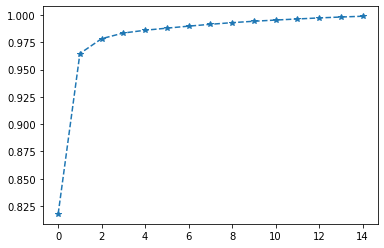

In [225]:
pca = decomposition.PCA(n_components=15).fit(tfidf_docs)
new_df = pca.transform(tfidf_docs)
var_exp = pca.explained_variance_ratio_
plt.plot(np.cumsum(pca.explained_variance_ratio_), '*--')

In [226]:
#2 темы лучше всего обьяснят дисперсию
PCA = decomposition.PCA(n_components=3)
PCA.fit(tfidf_docs)
tfidf_pca = PCA.transform(tfidf_docs)
columns = ['top{}'.format(i) for i in range(PCA.n_components)]
pca_df = pd.DataFrame(tfidf_pca, columns=columns)

df_with_topic = pd.concat([df_clean, pca_df], axis=1)
df_with_topic = df_with_topic.drop('describe', axis=1)
df_with_topic

,url,price,address,dist_to_metro,m2,r_apart,floor,floors_in_house,is_agent,is_hotel,top0,top1,top2
0,https://www.avito.ru/moskva/komnaty/komnata_16...,20000,"ул. Красного Маяка, 13Ак2",1600,16.0,3,6,9,0,0,0.103462,0.350112,0.214994
1,https://www.avito.ru/moskva/komnaty/komnata_12...,15000,"Широкая ул., 4к1",800,12.0,2,1,12,1,0,-0.003291,0.728462,-0.372453
2,https://www.avito.ru/moskva/komnaty/komnata_14...,15000,"ул. Артюхиной, 25",800,14.0,4,1,5,0,0,0.158198,0.840050,-0.424808
3,https://www.avito.ru/moskva/komnaty/komnata_24...,6500,"Москва, Новоданиловский проезд, 4",800,24.6,4,2,4,0,0,0.101529,0.886786,-0.413514
4,https://www.avito.ru/moskva/komnaty/komnata_11...,7000,Малая Семёновская ул.,400,11.0,1,1,2,1,0,0.072845,0.906061,-0.402509
...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,https://www.avito.ru/moskva/komnaty/komnata_16...,12000,"Бирюлёвская ул., 49к1",3400,16.0,2,6,12,0,0,0.799196,-0.102488,-0.003600
793,https://www.avito.ru/moskva/komnaty/komnata_10...,16000,"Елецкая ул., 16к2",900,10.0,3,6,9,0,0,-0.614566,-0.066775,-0.002939
794,https://www.avito.ru/moskva/komnaty/komnata_16...,20000,"Голубинская ул., 24к1",1200,16.0,3,15,16,0,0,0.799196,-0.102488,-0.003600
795,https://www.avito.ru/moskva/komnaty/komnata_16...,25000,"Тверская ул., 30/2с1",100,16.0,3,3,7,0,0,0.799196,-0.102488,-0.003600


## Визуализация данных и разделение на кластеры

### Стандартизирую данные

In [227]:
data_alg = ['price', 'dist_to_metro', 'm2', 'r_apart', 'floor', 
            'floors_in_house','is_agent','is_hotel', 'top0', 'top1', 'top2']
scaler = StandardScaler()
scaler.fit(df_with_topic[data_alg])
df_scaler = pd.DataFrame(scaler.transform(df_with_topic[data_alg]), columns=data_alg)

In [228]:
df_scaler

,price,dist_to_metro,m2,r_apart,floor,floors_in_house,is_agent,is_hotel,top0,top1,top2
0,1.067299,1.102310,-0.252871,0.297953,0.212690,-0.180280,-0.475556,-0.152008,0.153908,1.228738,2.480317
1,0.211102,-0.174407,-0.797494,-0.591443,-0.999856,0.357189,2.102800,-0.152008,-0.004895,2.556583,-4.296880
2,0.211102,-0.174407,-0.525182,1.187349,-0.999856,-0.896906,-0.475556,-0.152008,0.235332,2.948207,-4.900888
3,-1.244431,-0.174407,0.918070,1.187349,-0.757347,-1.076062,-0.475556,-0.152008,0.151033,3.112230,-4.770587
4,-1.158812,-0.812766,-0.933650,-1.480839,-0.999856,-1.434375,2.102800,-0.152008,0.108362,3.179878,-4.643628
...,...,...,...,...,...,...,...,...,...,...,...
792,-0.302615,3.974923,-0.252871,-0.591443,0.212690,0.357189,-0.475556,-0.152008,1.188869,-0.359690,-0.041534
793,0.382342,-0.014818,-1.069806,0.297953,0.212690,-0.180280,-0.475556,-0.152008,-0.914217,-0.234349,-0.033906
794,1.067299,0.463951,-0.252871,0.297953,2.395273,1.073814,-0.475556,-0.152008,1.188869,-0.359690,-0.041534
795,1.923495,-1.291535,-0.252871,0.297953,-0.514838,-0.538593,-0.475556,-0.152008,1.188869,-0.359690,-0.041534


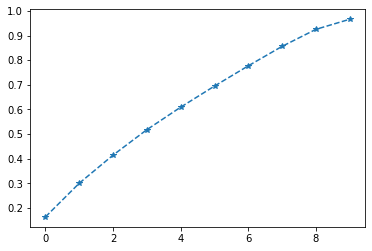

In [229]:
pca = decomposition.PCA(n_components=10).fit(df_scaler)
new_df = pca.transform(df_scaler)
var_exp = pca.explained_variance_ratio_
#x_new = pd.DataFrame(x_new, columns=['x', 'y'])

plt.plot(np.cumsum(pca.explained_variance_ratio_), '*--')

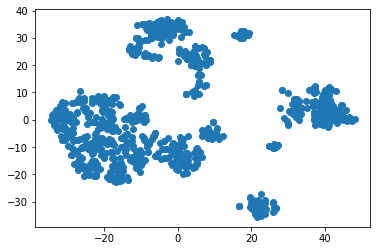

In [230]:
#По графику, оптимальное количество кластеров - 4.
rooms_TNE = TSNE(n_components=2).fit_transform(df_scaler)
rooms_TNE = pd.DataFrame(rooms_TNE, columns=['x', 'y'])

plt.scatter(rooms_TNE['x'], rooms_TNE['y'])

In [231]:
avg = []
for i in range(2, 20):
    Kmeans = KMeans(n_clusters=i, random_state=42, max_iter=60)
    Kmeans.fit(df_scaler)
    y_labels = Kmeans.labels_
    
    silhouette_avg = silhouette_score(df_scaler, y_labels)
    
    avg.append(silhouette_avg)
#Оценка в целом остаётся постоянной(
pd.DataFrame(avg, columns=['silhouette'])

,silhouette
0,0.170501
1,0.188455
2,0.196308
3,0.225952
4,0.214626
5,0.223316
6,0.237008
7,0.252674
8,0.224383
9,0.226238


In [232]:
#Возьму 4 кластера
Kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)
Kmeans.fit(df_scaler)
y_labels = Kmeans.labels_

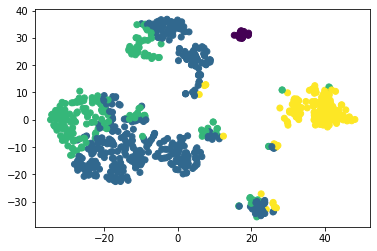

In [233]:
df_kmeans = rooms_TNE.copy()
df_kmeans['labels'] = y_labels

#4 кластера выглядят неплохо
plt.scatter(df_kmeans['x'], df_kmeans['y'], c=df_kmeans['labels'])

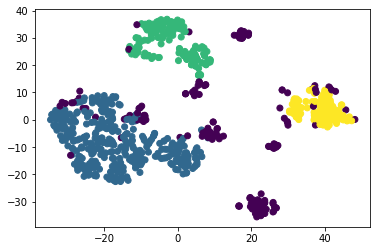

In [234]:
#А что скажет DBScan?
db = DBSCAN(eps=1.7, min_samples=10).fit(df_scaler)
labels = db.labels_
df_dbscan = rooms_TNE.copy()
df_dbscan['labels'] = labels

#Думаю разделение прошло неплохо и вместе с тем выделились аномалии.
plt.scatter(df_dbscan['x'], df_dbscan['y'], c=df_dbscan['labels'])

In [235]:
#Добавляю кластеры в новую фичу
df_with_clust = df_scaler.copy()
df_with_clust['DBScan'] = labels
df_with_clust['KMeans'] = y_labels
df_with_clust

,price,dist_to_metro,m2,r_apart,floor,floors_in_house,is_agent,is_hotel,top0,top1,top2,DBScan,KMeans
0,1.067299,1.102310,-0.252871,0.297953,0.212690,-0.180280,-0.475556,-0.152008,0.153908,1.228738,2.480317,-1,1
1,0.211102,-0.174407,-0.797494,-0.591443,-0.999856,0.357189,2.102800,-0.152008,-0.004895,2.556583,-4.296880,-1,3
2,0.211102,-0.174407,-0.525182,1.187349,-0.999856,-0.896906,-0.475556,-0.152008,0.235332,2.948207,-4.900888,-1,1
3,-1.244431,-0.174407,0.918070,1.187349,-0.757347,-1.076062,-0.475556,-0.152008,0.151033,3.112230,-4.770587,-1,1
4,-1.158812,-0.812766,-0.933650,-1.480839,-0.999856,-1.434375,2.102800,-0.152008,0.108362,3.179878,-4.643628,-1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,-0.302615,3.974923,-0.252871,-0.591443,0.212690,0.357189,-0.475556,-0.152008,1.188869,-0.359690,-0.041534,-1,2
793,0.382342,-0.014818,-1.069806,0.297953,0.212690,-0.180280,-0.475556,-0.152008,-0.914217,-0.234349,-0.033906,0,1
794,1.067299,0.463951,-0.252871,0.297953,2.395273,1.073814,-0.475556,-0.152008,1.188869,-0.359690,-0.041534,1,2
795,1.923495,-1.291535,-0.252871,0.297953,-0.514838,-0.538593,-0.475556,-0.152008,1.188869,-0.359690,-0.041534,1,1


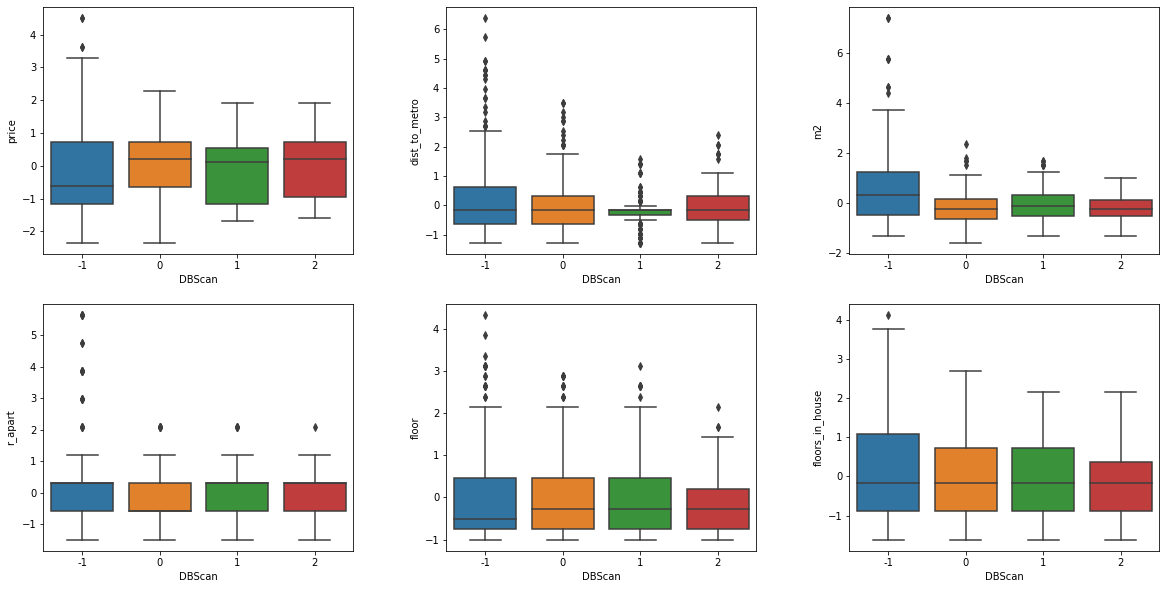

In [236]:
#Судя по boxplot у DBScan плохое разделение
fig, ax = plt.subplots(nrows=2, ncols=3)

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(20, 10)

sns.boxplot(x='DBScan', y='price', data=df_with_clust, ax=ax[0, 0])
sns.boxplot(x='DBScan', y='dist_to_metro', data=df_with_clust, ax=ax[0, 1])
sns.boxplot(x='DBScan', y='m2', data=df_with_clust, ax=ax[0, 2])

sns.boxplot(x='DBScan', y='r_apart', data=df_with_clust, ax=ax[1, 0])
sns.boxplot(x='DBScan', y='floor', data=df_with_clust, ax=ax[1, 1])
sns.boxplot(x='DBScan', y='floors_in_house', data=df_with_clust, ax=ax[1, 2])

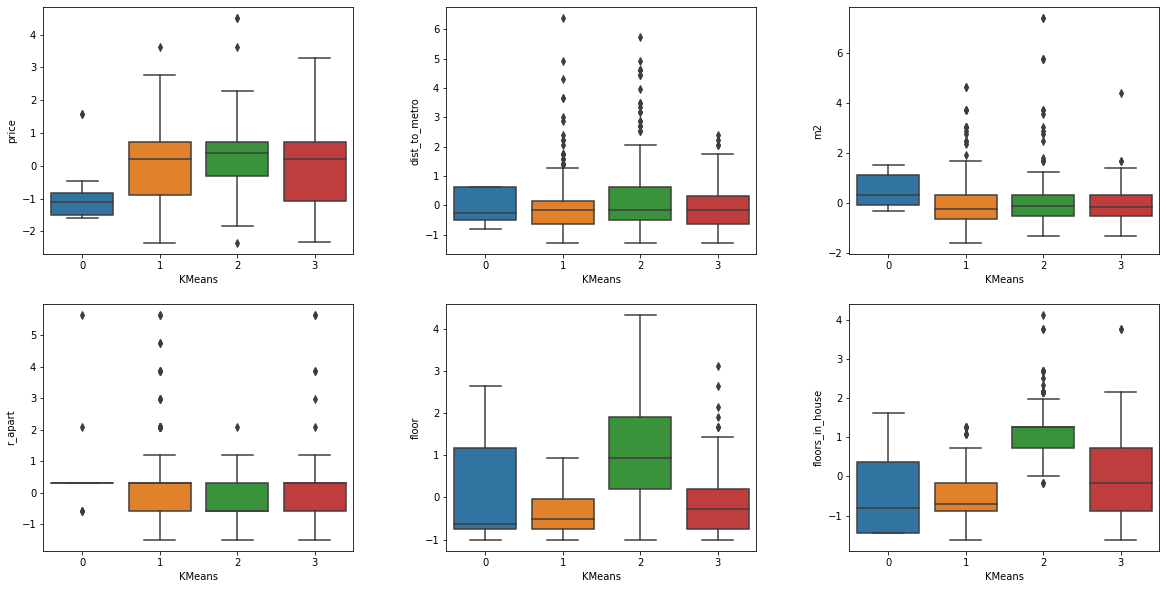

In [237]:
#KMeans справился лучше
fig, ax = plt.subplots(nrows=2, ncols=3)

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(20, 10)

sns.boxplot(x='KMeans', y='price', data=df_with_clust, ax=ax[0, 0])
sns.boxplot(x='KMeans', y='dist_to_metro', data=df_with_clust, ax=ax[0, 1])
sns.boxplot(x='KMeans', y='m2', data=df_with_clust, ax=ax[0, 2])

sns.boxplot(x='KMeans', y='r_apart', data=df_with_clust, ax=ax[1, 0])
sns.boxplot(x='KMeans', y='floor', data=df_with_clust, ax=ax[1, 1])
sns.boxplot(x='KMeans', y='floors_in_house', data=df_with_clust, ax=ax[1, 2])

In [238]:
df_with_clust.drop('DBScan', axis=1, inplace=True)
df_with_clust

,price,dist_to_metro,m2,r_apart,floor,floors_in_house,is_agent,is_hotel,top0,top1,top2,KMeans
0,1.067299,1.102310,-0.252871,0.297953,0.212690,-0.180280,-0.475556,-0.152008,0.153908,1.228738,2.480317,1
1,0.211102,-0.174407,-0.797494,-0.591443,-0.999856,0.357189,2.102800,-0.152008,-0.004895,2.556583,-4.296880,3
2,0.211102,-0.174407,-0.525182,1.187349,-0.999856,-0.896906,-0.475556,-0.152008,0.235332,2.948207,-4.900888,1
3,-1.244431,-0.174407,0.918070,1.187349,-0.757347,-1.076062,-0.475556,-0.152008,0.151033,3.112230,-4.770587,1
4,-1.158812,-0.812766,-0.933650,-1.480839,-0.999856,-1.434375,2.102800,-0.152008,0.108362,3.179878,-4.643628,3
...,...,...,...,...,...,...,...,...,...,...,...,...
792,-0.302615,3.974923,-0.252871,-0.591443,0.212690,0.357189,-0.475556,-0.152008,1.188869,-0.359690,-0.041534,2
793,0.382342,-0.014818,-1.069806,0.297953,0.212690,-0.180280,-0.475556,-0.152008,-0.914217,-0.234349,-0.033906,1
794,1.067299,0.463951,-0.252871,0.297953,2.395273,1.073814,-0.475556,-0.152008,1.188869,-0.359690,-0.041534,2
795,1.923495,-1.291535,-0.252871,0.297953,-0.514838,-0.538593,-0.475556,-0.152008,1.188869,-0.359690,-0.041534,1


In [239]:
df_with_clust

,price,dist_to_metro,m2,r_apart,floor,floors_in_house,is_agent,is_hotel,top0,top1,top2,KMeans
0,1.067299,1.102310,-0.252871,0.297953,0.212690,-0.180280,-0.475556,-0.152008,0.153908,1.228738,2.480317,1
1,0.211102,-0.174407,-0.797494,-0.591443,-0.999856,0.357189,2.102800,-0.152008,-0.004895,2.556583,-4.296880,3
2,0.211102,-0.174407,-0.525182,1.187349,-0.999856,-0.896906,-0.475556,-0.152008,0.235332,2.948207,-4.900888,1
3,-1.244431,-0.174407,0.918070,1.187349,-0.757347,-1.076062,-0.475556,-0.152008,0.151033,3.112230,-4.770587,1
4,-1.158812,-0.812766,-0.933650,-1.480839,-0.999856,-1.434375,2.102800,-0.152008,0.108362,3.179878,-4.643628,3
...,...,...,...,...,...,...,...,...,...,...,...,...
792,-0.302615,3.974923,-0.252871,-0.591443,0.212690,0.357189,-0.475556,-0.152008,1.188869,-0.359690,-0.041534,2
793,0.382342,-0.014818,-1.069806,0.297953,0.212690,-0.180280,-0.475556,-0.152008,-0.914217,-0.234349,-0.033906,1
794,1.067299,0.463951,-0.252871,0.297953,2.395273,1.073814,-0.475556,-0.152008,1.188869,-0.359690,-0.041534,2
795,1.923495,-1.291535,-0.252871,0.297953,-0.514838,-0.538593,-0.475556,-0.152008,1.188869,-0.359690,-0.041534,1


## Поиск аномалий

In [240]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, contamination=0.05, max_features=0.9, bootstrap=True)
preds = model.fit_predict(df_with_clust)

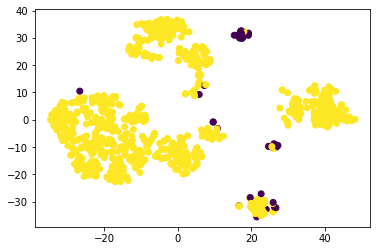

In [241]:
df_forest_anomaly = rooms_TNE.copy()
df_forest_anomaly['labels'] = preds

plt.scatter(df_forest_anomaly['x'], df_forest_anomaly['y'], c=df_forest_anomaly['labels'])

In [242]:
df_clean['forest_anomaly'] = df_forest_anomaly['labels']
df_with_clust['forest_anomaly'] = df_forest_anomaly['labels']

In [243]:
df_clean[df_clean['forest_anomaly'] == -1]['url'].count()

40

In [245]:
# Фактически такиим образом находим общаги.
df_clean[df_clean['forest_anomaly'] == -1]['url'].unique()[:10]

array(['https://www.avito.ru/moskva/komnaty/komnata_11_m_v_1-k_12_et._1835529430',
       'https://www.avito.ru/moskva/komnaty/komnata_30_m_v_1-k_1214_et._1826355439',
       'https://www.avito.ru/moskva/komnaty/komnata_223_m_v_3-k.510_et._1915535682',
       'https://www.avito.ru/moskva/komnaty/komnata_27_m_v_3-k.431_et._2139588950',
       'https://www.avito.ru/moskva/komnaty/komnata_14_m_v_2-k.22_et._1614746219',
       'https://www.avito.ru/moskva/komnaty/komnata_14_m_v_2-k.1112_et._2131285167',
       'https://www.avito.ru/moskva/komnaty/komnata_16_m_v_3-k.1112_et._2107086211',
       'https://www.avito.ru/moskva/komnaty/komnata_19m_v_3-k._26et._1796102825',
       'https://www.avito.ru/moskva/komnaty/komnata_20_m_v_2-k.1822_et._1971722037',
       'https://www.avito.ru/moskva/komnaty/komnata_72_m_v_3-k.212_et._2060660593'],
      dtype=object)

Либо дорогие комнаты находящиеся далеко от метро, либо дорогие общаги

In [246]:
df_with_clust['forest_anomaly'] = df_with_clust['forest_anomaly'].map({1: 0, -1: 1})
df_clean['forest_anomaly'] = df_clean['forest_anomaly'].map({1: 0, -1: 1})

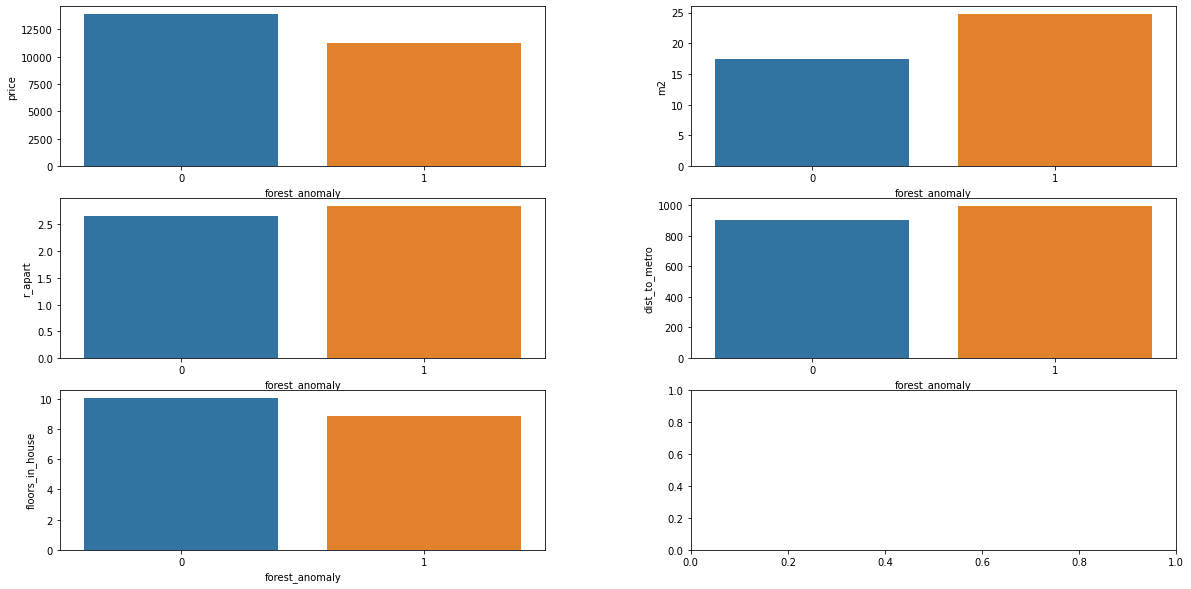

In [247]:
mean_price = df_clean.groupby('forest_anomaly')['price'].mean()
mean_m2 = df_clean.groupby('forest_anomaly')['m2'].mean()
mean_r_apart = df_clean.groupby('forest_anomaly')['r_apart'].mean()
mean_dist_to_metro = df_clean.groupby('forest_anomaly')['dist_to_metro'].mean()
mean_floors_in_house = df_clean.groupby('forest_anomaly')['floors_in_house'].mean()

fig, ax = plt.subplots(nrows=3, ncols=2) 

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(20, 10)

sns.barplot(mean_price.index, mean_price, ax=ax[0, 0])
sns.barplot(mean_m2.index, mean_m2,  ax=ax[0, 1])
sns.barplot(mean_r_apart.index, mean_r_apart, ax=ax[1, 0])
sns.barplot(mean_dist_to_metro.index, mean_dist_to_metro,  ax=ax[1, 1])
sns.barplot(mean_floors_in_house.index, mean_floors_in_house, ax=ax[2, 0])